In [117]:
import json
import numpy as np
import pandas as pd
import collections
import nltk
import itertools

Load previous cleaned JSON file.

In [2]:
with open('comments_cleaned.json', 'r') as fp:
    loaded_data = json.load(fp)

Load car brand and model look up.

In [85]:
model_lookup = pd.read_csv('models.csv',header=None)

In [87]:
model_lookup.shape

(531, 9)

In [86]:
brands_np = model_lookup.iloc[:,0].unique()
model_np = model_lookup.iloc[:,1].unique()
len(model_np)

526

In [88]:
[item for item, count in collections.Counter(model_lookup.iloc[:,1]).items() if count > 1]

['Legend', 'Matrix', 'optima', 'passat']

Note that we have model names that's associated with two brands.

In [8]:
loaded_data.keys()

dict_keys(['page', 'comment_id', 'user_id', 'date', 'comment', 'comment_tokenized', 'tagged_filtered_sentence'])

Select the first 5000 comments. Transform tagged sentences, keep only singular nouns.

In [76]:
tagged_sentences = loaded_data['tagged_filtered_sentence'][:5000]

In [77]:
tagged_sentences_lower = []
noun_tags = ['FW','NN','NNS','NNP','NNPS','SYM']
stemmer = nltk.PorterStemmer()
for sentence in tagged_sentences:
    new_sentence = []
    for word_t in sentence:
        if word_t[1] in noun_tags:
            if word_t[1] == 'NNS':
                word_t[0] = stemmer.stem(word_t[0])
                word_t[1] = 'NN'
            elif word_t[1] == 'NNPS':
                word_t[0] = stemmer.stem(word_t[0])
                word_t[1] = 'NNP'
            new_sentence.append(word_t[0])
    tagged_sentences_lower.append(new_sentence)

In [99]:
tagged_sentences_lower[8]

['RX-8',
 'G35',
 'coupe',
 'Saturn',
 'ION',
 'coupe',
 'door',
 'S40',
 'size',
 'Mazda3',
 'Focus.I',
 'sedan',
 'title',
 'Compass',
 'wagon',
 'SUV']

In [98]:
loaded_data['comment'][8]

'I wouldn\'t consider the RX-8, G35 coupe, or Saturn ION coupe to be midsized, no matter how many doors they have. I don\'t think the S40 is midsized either, being the same size as a Mazda3 or Focus.I think since "sedans" is in the title, the Compass (which is too small to be midsized anyway), wagons shouldn\'t count, gloried as a wanna-be SUV or not. '

Count the appearence of each brand for each of the comment.

Assumptions:

If we observed a model that has more than two associated brands:
- check if one of the associated brand has been captured, this model would then count under that brand
- if no information is captured, count this model under the brand that appears first in the look up table in alphabet order

In [89]:
def count_brand(sentence):
    result = []
    # lower case all strings
    sentence_lower = [x.lower() for x in sentence]
    # drop duplicates
    sentence_lower = list(dict.fromkeys(sentence_lower))
    # go through the list of car brands
    for brand in brands_np:
        if brand.lower() in sentence_lower:
            if brand.lower() not in result:
                result.append(brand.lower())
    # go through the model list, retraive brand info
    for i,model in enumerate(model_lookup.iloc[:,1]):
        candidate_brands = []
        for j,word in enumerate(sentence_lower):
            if model.lower() == word:
                candidate_brands.append(model_lookup.iloc[i,0])
        if len(candidate_brands) == 1 and candidate_brands[0].lower() not in result:
            result.append(candidate_brands[0].lower())
        elif len(candidate_brands) > 1:
            flg = 0
            for brand_c in candidate_brands:
                if brand_c in result_dict:
                    flg += 1
            if flg == 0:
                result.append(candidate_brands[0].lower())
                    
    return result
                    
            

In [90]:
count_brand(tagged_sentences_lower[8])

['saturn', 'sedan', 'ford', 'mazda']

In [91]:
brands_in_comments = list(map(lambda x: count_brand(x), tagged_sentences_lower))

In [92]:
brands_in_comments[4]

['car',
 'ford',
 'hyundai',
 'kia',
 'mazda',
 'nissan',
 'seat',
 'honda',
 'saturn',
 'toyota']

In [95]:
lst_of_brands_comments = list({x for l in brands_in_comments for x in l})

In [96]:
len(lst_of_brands_comments)

30

Brands info is extracted from each comment, with one brand only counted once. Now under each brand we count its appearance.

In [104]:
brand_count = [0]*len(lst_of_brands_comments)
for i,brand in enumerate(lst_of_brands_comments):
    for comment_info in brands_in_comments:
        if brand in comment_info:
            brand_count[i] += 1
                

In [111]:
sorted_brand_count = pd.DataFrame({'brand':lst_of_brands_comments,'count':brand_count}).sort_values(by='count',ascending=False).reset_index(drop=True)
sorted_brand_count.to_csv('brand_count.csv',index=False)

## Brand Association and lift

We need to remove terms that are not brands first, e.g., car, sedan, seat, problem

In [115]:
remove_terms = ['car','problem','sedseatan','']
lst_of_brands = [x for x in lst_of_brands_comments if x not in remove_terms]

In [116]:
len(lst_of_brands)

26

In [121]:
combos = list(itertools.combinations(lst_of_brands, 2))

In [129]:
combos_count = [0] * len(combos)
brand_1 = []
brand_2 = []
for i,c in enumerate(combos):
    brand_1.append(c[0])
    brand_2.append(c[1])
    for brands in brands_in_comments:
        if c[0] in brands and c[1] in brands:
            combos_count[i] += 1

In [130]:
mention_combo = pd.DataFrame({'brand1':brand_1,'brand2':brand_2,'count':combos_count})
mention_combo

,brand1,brand2,count
0,mercedes,nissan,3
1,mercedes,buick,2
2,mercedes,honda,12
3,mercedes,cadillac,1
4,mercedes,chrysler,1
...,...,...,...
320,mercury,chevrolet,9
321,mercury,dodge,5
322,mitsubishi,chevrolet,7
323,mitsubishi,dodge,3


In [143]:
full_count_1 = mention_combo.merge(sorted_brand_count, left_on='brand1', right_on='brand',suffixes=('_joint', '_brand1')).drop(columns=['brand'])
full_count_1

,brand1,brand2,count_joint,count_brand1
0,mercedes,nissan,3,26
1,mercedes,buick,2,26
2,mercedes,honda,12,26
3,mercedes,cadillac,1,26
4,mercedes,chrysler,1,26
...,...,...,...,...
320,mercury,chevrolet,9,81
321,mercury,dodge,5,81
322,mitsubishi,chevrolet,7,46
323,mitsubishi,dodge,3,46


In [148]:
N = 5000
full_count = full_count_1.merge(sorted_brand_count, left_on='brand2', right_on='brand').drop(columns=['brand'])
full_count.columns = list(full_count.columns)[:-1] + ['count_brand2']
full_count['lift'] = (full_count.count_joint/(full_count.count_brand1*full_count.count_brand2)) * N
full_count

,brand1,brand2,count_joint,count_brand1,count_brand2,lift
0,mercedes,nissan,3,26,514,1.122418
1,mercedes,buick,2,26,57,6.747638
2,nissan,buick,15,514,57,2.559902
3,mercedes,honda,12,26,2061,1.119695
4,nissan,honda,312,514,2061,1.472596
...,...,...,...,...,...,...
320,saturn,dodge,3,231,72,0.901876
321,hyundai,dodge,12,576,72,1.446759
322,mercury,dodge,5,81,72,4.286694
323,mitsubishi,dodge,3,46,72,4.528986


In [206]:
full_count.to_csv('count_and_lift.csv',index=False)

Construct a dissimilarity matrix with lift.

In [187]:
lift_matrix = {}
for brand_a in lst_of_brands:
    #print('A:',brand_a)
    lift_matrix[brand_a] = []
    sub_lift_df1 = full_count[full_count.brand1 == brand_a]
    for brand_b in lst_of_brands:
        #print('B:',brand_b)
        sub_lift_df2 = sub_lift_df1[sub_lift_df1.brand2 == brand_b]
        if len(sub_lift_df2) == 0:
            #try opposite order combo
            sub_lift_df3 = full_count[full_count.brand2 == brand_a]
            sub_lift_df4 = sub_lift_df3[sub_lift_df3.brand1 == brand_b]
            if len(sub_lift_df4) > 0:
                value_0 = sub_lift_df4['lift'].values[0]
                if value_0 != 0:
                    lift_matrix[brand_a].append(1/value_0)
                else:
                    lift_matrix[brand_a].append(value_0)
            else:
                lift_matrix[brand_a].append(0)
        else:
            value_1 = sub_lift_df2['lift'].values[0]
            if value_1 != 0:
                lift_matrix[brand_a].append(1/value_1)
            else:
                lift_matrix[brand_a].append(value_1)

In [189]:
dissimilarity_df = pd.DataFrame(lift_matrix)

In [190]:
dissimilarity_df

,mercedes,nissan,buick,honda,cadillac,chrysler,ford,pontiac,suzuki,bmw,...,volkswagen,lincoln,acura,mazda,saturn,hyundai,mercury,mitsubishi,chevrolet,dodge
0,0.000000,0.890933,0.148200,0.893100,0.130000,1.097200,0.773644,0.000000,0.00000,0.043200,...,0.520000,0.000000,0.000000,2.870400,1.201200,0.499200,0.421200,0.000000,0.407333,0.000000
1,0.890933,0.000000,0.390640,0.679073,1.285000,0.943078,0.834238,0.319822,0.41120,0.740160,...,0.354483,2.313000,0.783850,0.637591,0.316624,0.569354,0.438253,0.675543,0.483160,1.850400
2,0.148200,0.390640,0.000000,0.939816,0.057000,0.601350,0.803400,0.058036,0.00000,0.410400,...,0.285000,0.000000,0.231800,0.629280,0.188100,1.313280,0.461700,0.524400,0.157588,0.205200
3,0.893100,0.679073,0.939816,0.000000,1.288125,0.712903,0.853069,0.795972,1.09920,0.872894,...,0.777736,1.854900,0.534983,0.861873,0.743892,0.690195,0.834705,1.458554,0.733841,0.989280
4,0.130000,1.285000,0.057000,1.288125,0.000000,0.527500,1.339000,0.046667,0.00000,0.135000,...,0.000000,0.000000,0.000000,0.920000,0.192500,1.440000,0.000000,0.000000,0.146875,0.000000
5,1.097200,0.943078,0.601350,0.712903,0.527500,0.000000,0.774052,0.787733,0.16880,0.911520,...,2.110000,0.949500,2.574200,1.294133,1.218525,0.656951,1.139400,0.647067,0.619813,0.132104
6,0.773644,0.834238,0.803400,0.853069,1.339000,0.774052,0.000000,1.071200,0.42848,1.606800,...,1.115833,0.286929,1.089053,0.835173,0.736450,0.852225,0.344314,0.947600,0.749202,0.918171
7,0.000000,0.319822,0.058036,0.795972,0.046667,0.787733,1.071200,0.000000,0.00000,0.000000,...,0.373333,0.000000,0.227733,0.772800,0.099508,0.645120,0.302400,0.257600,0.071135,0.268800
8,0.000000,0.411200,0.000000,1.099200,0.000000,0.168800,0.428480,0.000000,0.00000,0.000000,...,0.000000,0.072000,0.097600,0.000000,0.000000,0.460800,0.129600,0.000000,0.000000,0.115200
9,0.043200,0.740160,0.410400,0.872894,0.135000,0.911520,1.606800,0.000000,0.00000,0.000000,...,0.308571,0.972000,0.146400,0.701365,0.997920,0.622080,0.000000,0.993600,0.725143,0.000000


In [192]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

mds = MDS(n_components=2,random_state=0, dissimilarity='precomputed')
data_transformed = mds.fit_transform(dissimilarity_df)
data_transformed

array([[ 0.37426877, -0.03991939],
       [-0.49029836,  0.24358951],
       [ 0.12598988,  0.10307309],
       [-0.78056476,  0.16135932],
       [ 0.25265653,  0.04766292],
       [ 0.04289791, -0.72887561],
       [-0.68968117, -0.49340668],
       [ 0.14776558,  0.03118089],
       [ 0.07599427,  0.01420596],
       [ 0.30233764,  0.23764789],
       [ 0.12109704, -0.24032506],
       [-0.45411026, -0.12892136],
       [ 0.21712098,  0.03235472],
       [ 0.28200139, -0.00685159],
       [ 0.22160646,  0.06123809],
       [-0.11161404,  0.35255476],
       [ 0.10573393,  0.25852539],
       [ 0.45954555, -0.07292511],
       [ 0.36778141,  0.27996369],
       [-0.39449736,  0.72059479],
       [-0.39977099,  0.02872274],
       [-0.37355259, -0.45682549],
       [ 0.04089337,  0.05913749],
       [ 0.26540754, -0.11710561],
       [-0.08787188, -0.15834385],
       [ 0.37886317, -0.18831149]])

In [198]:
len(data_transformed)

26

In [199]:
len(lst_of_brands)

26

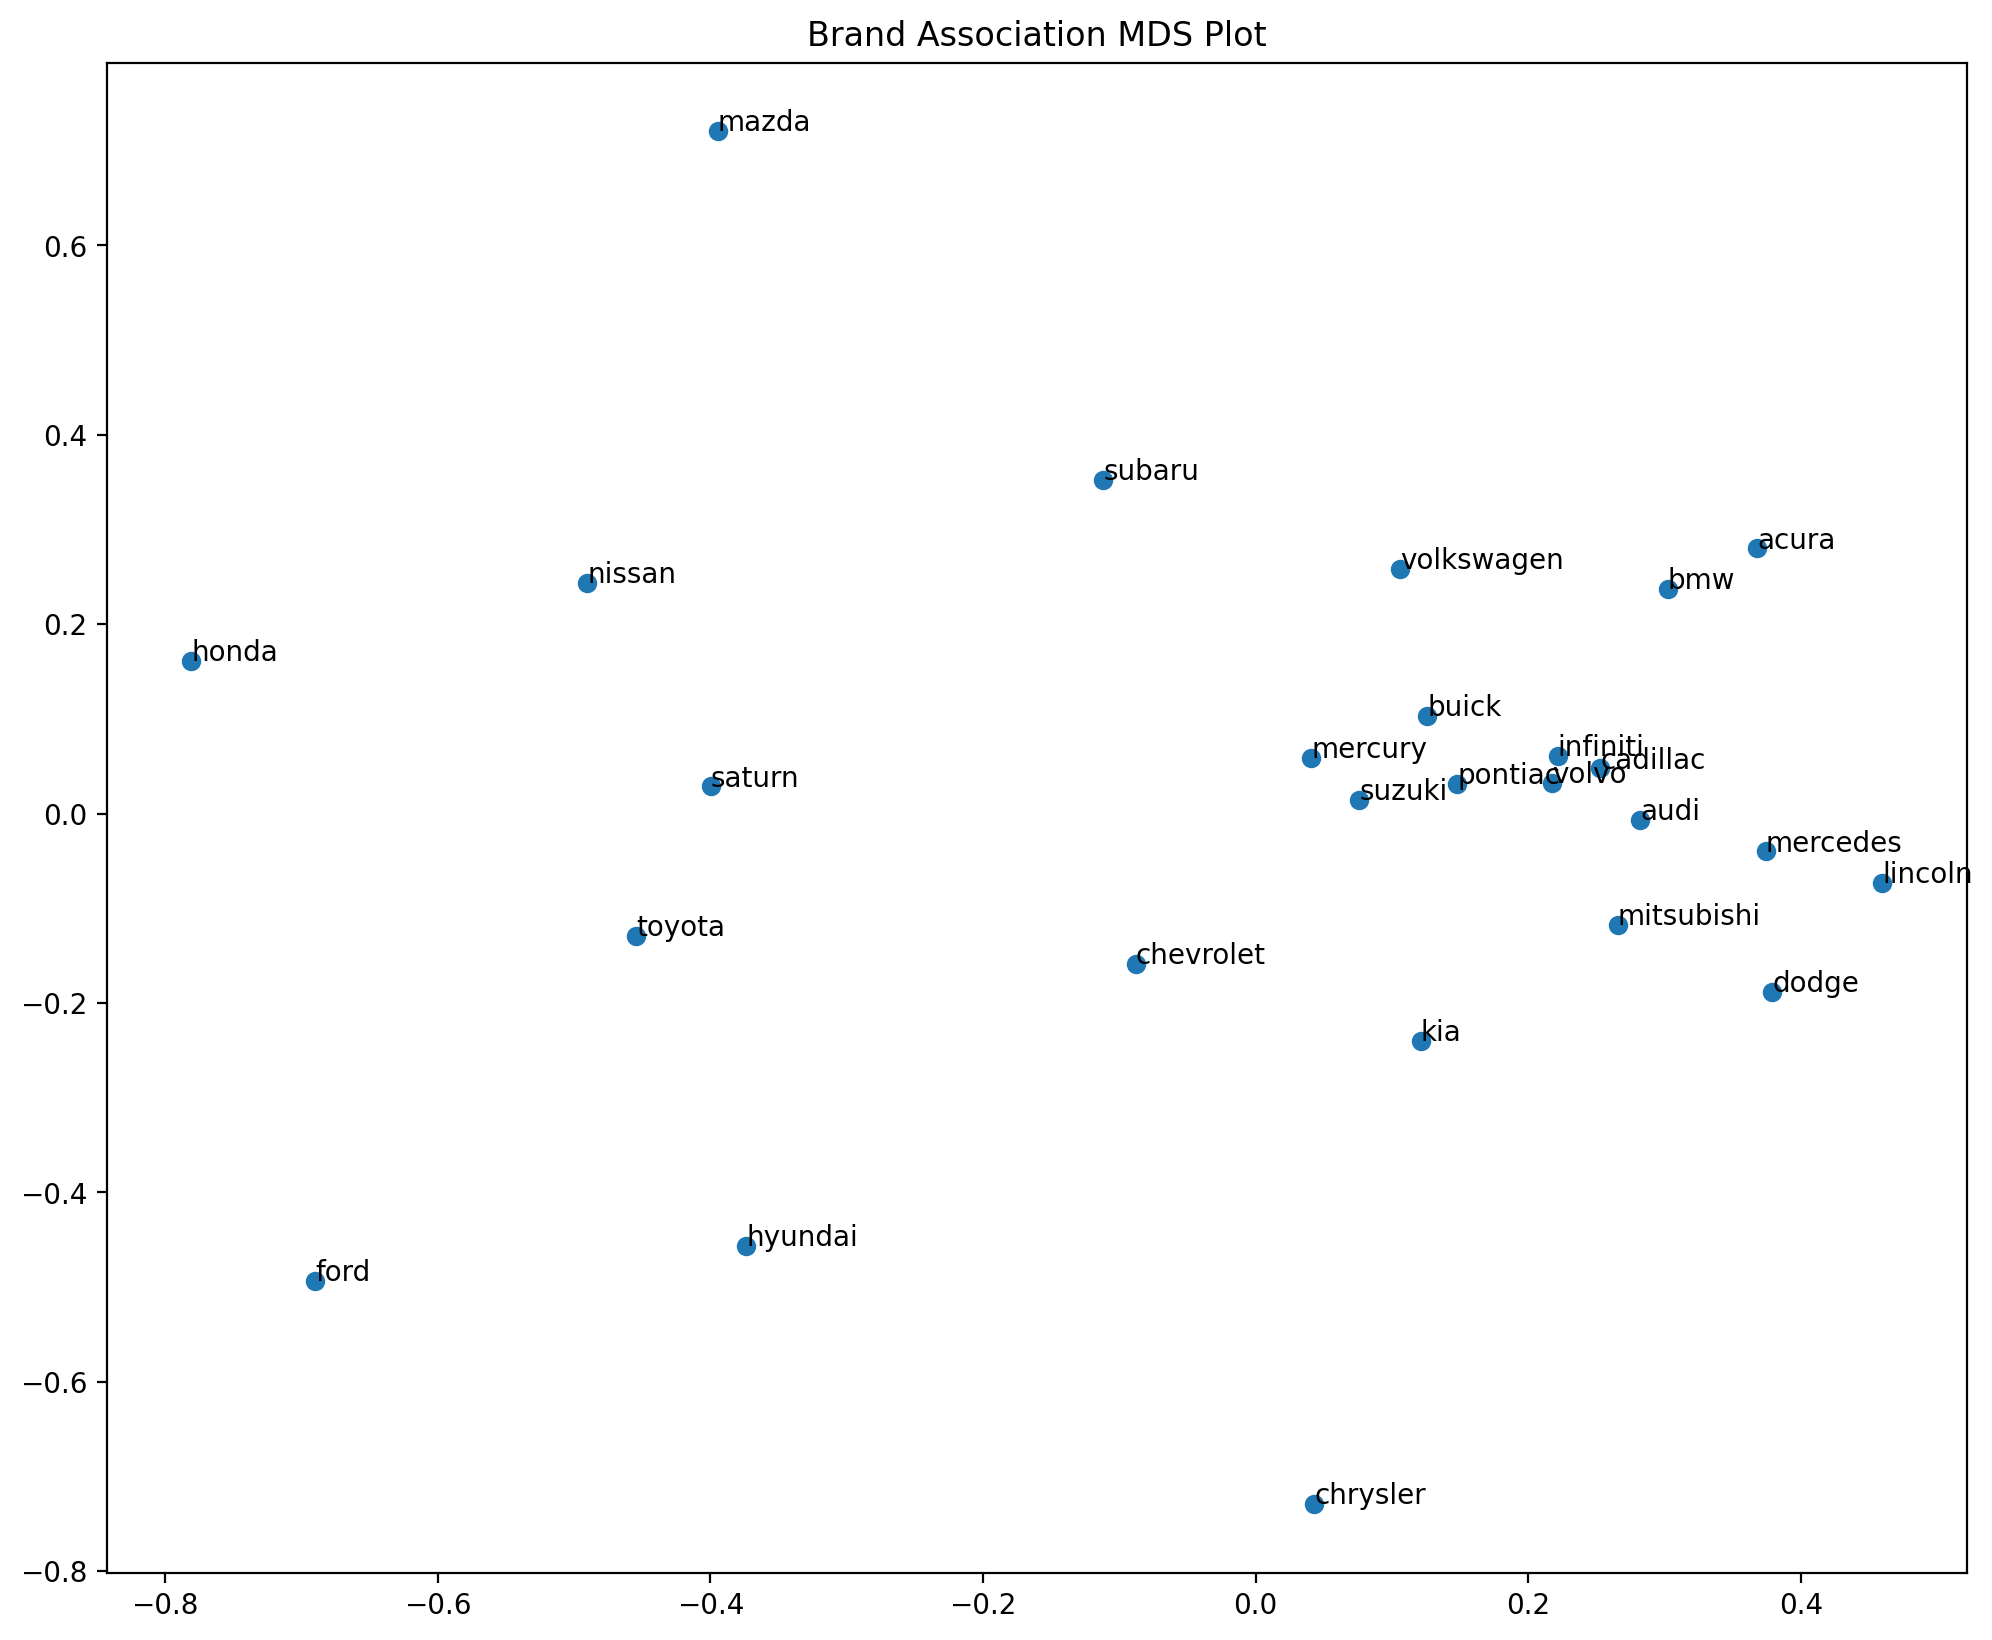

In [205]:
from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=200)
plt.scatter(data_transformed[:,0],data_transformed[:,1])
plt.title('Brand Association MDS Plot')
for i, txt in enumerate(lst_of_brands):
    plt.annotate(txt, (data_transformed[i,0], data_transformed[i,1]))
plt.show()